In [2]:
!pip install geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 4.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 5.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 5.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 2.3 MB/s eta 0:00:0000:0100:01


In [2]:
from glob import glob
import numpy as np
from scipy.io import loadmat
import rasterio as rio
from rasterio import mask
import geopandas as gpd
from rasterio.plot import show

from sklearn import cluster
from osgeo import gdal, gdal_array
import matplotlib.pyplot as plt

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

In [3]:
#S_sentinel_bands = glob("/home/jovyan/satData/S2B_MSIL2A_20230612T073619_N0509_R092_T37NCC_20230612T101141.SAFE/GRANULE/L2A_T37NCC_A032722_20230612T075442/IMG_DATA/*R1*/*B?*.jp2")
S_sentinel_bands = glob("/home/jovyan/results/WIZcropped4bands_to_aoi.tiff")
S_sentinel_bands.sort()

#S_sentinel_bands = clipped_bands

l = []
for i in S_sentinel_bands:
  with rio.open(i, 'r') as f:
      print (i)
      l.append(f.read(1))

/home/jovyan/results/WIZcropped4bands_to_aoi.tiff


In [4]:
# numpy array
arr_st = np.stack(l)

In [5]:
# gdal array
for i in S_sentinel_bands:
    img_ds = gdal.Open(i, gdal.GA_ReadOnly)
    
    img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
                  gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
    
    for b in range(img.shape[2]):
        img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
        

In [6]:
new_shape = (img.shape[0] * img.shape[1], img.shape[2])

In [7]:
X = img[:, :, :4].reshape(new_shape)

In [8]:
k_means = cluster.KMeans(n_clusters=8, n_init=10)
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img[:, :, 0].shape)

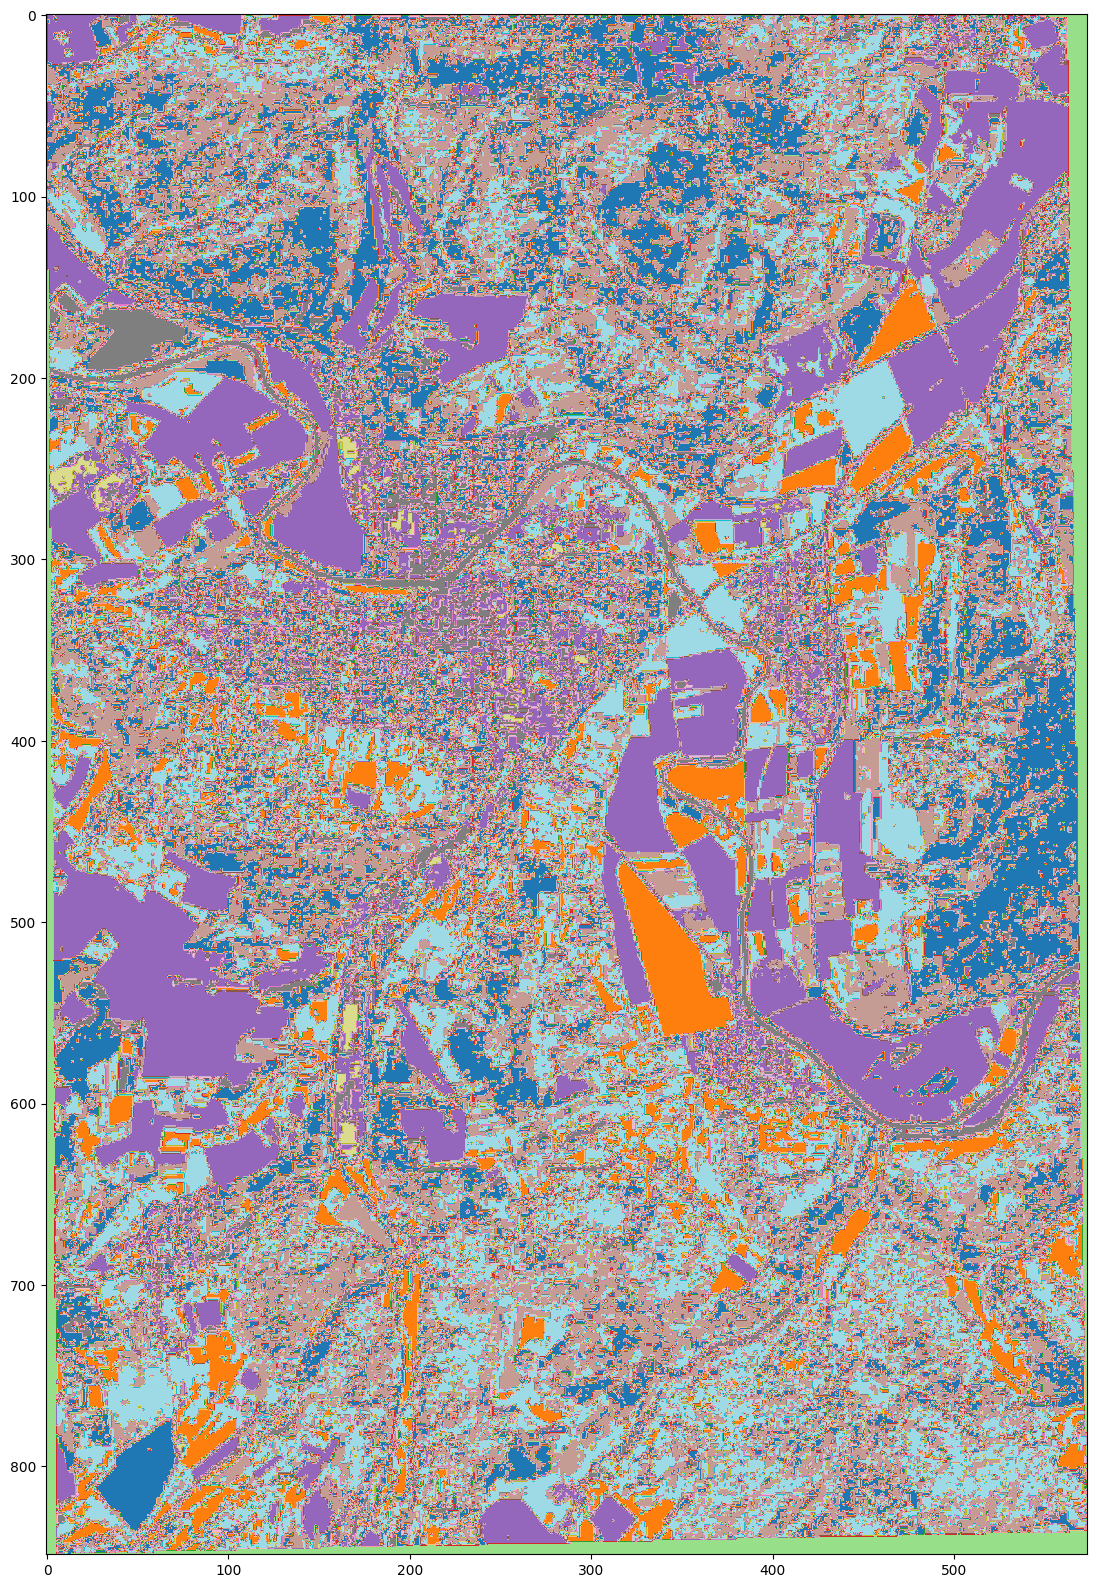

In [15]:
plt.figure(figsize=(20,20))
plt.imshow(X_cluster, cmap="tab20")

plt.show()

In [16]:
type(X_cluster)

numpy.ndarray

In [18]:
with rio.open(S_sentinel_bands[0]) as src:
    meta = src.meta
    transform = meta['transform']

with rio.open('/home/jovyan/results/classified/wiz_unsupervised_croppped.tiff', 'w', **meta) as dst:
    dst.write(X_cluster, indexes=1)

In [13]:
img.shape

(849, 574, 4)

In [14]:
meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 574,
 'height': 849,
 'count': 4,
 'crs': CRS.from_epsg(32632),
 'transform': Affine(10.0, 0.0, 557490.0,
        0.0, -10.0, 5691580.0)}